In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="3"

In [2]:
#!pip install xformers

In [3]:
from PIL import Image
import json
import matplotlib.pyplot as plt

from vis_prior.utils import *
from vis_prior.vis_prior_layout import UniformRandomNoClipVPL
from vis_prior.vis_prior_generator import CannyVPG, HEDVPG, MLSDVPG, MidasVPG, UniformerVPG

import sys
sys.path.append("/home/ubuntu/dad/ControlNet")
from share import *
import config
import cv2
import einops
# import gradio as gr
import numpy as np
import torch
import random

from pytorch_lightning import seed_everything
from annotator.util import resize_image, HWC3
from cldm.model import create_model, load_state_dict
from cldm.ddim_hacked import DDIMSampler

/opt/conda/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")


logging improved.


In [4]:
labels_path="/media/data/coco17/coco/seed1/30shot_novel.json"
im_folder = "/media/data/coco17/coco/train2017/"
naive_vpd = UniformRandomNoClipVPL()
hedVPG = HEDVPG(vpl=naive_vpd, fill_val=0, annotation=labels_path, im_folder=im_folder)

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Given input size: (512x5x1). Calculated output size: (512x2x0). Output size is too small
failed to detect annotation: 1252442
Given input size: (512x3x1). Calculated output size: (512x1x0). Output size is too small
failed to detect annotation: 1333378
Given input size: (512x1x5). Calculated output size: (512x0x2). Output size is too small
failed to detect annotation: 1803201
Given input size: (512x1x3). Calculated output size: (512x0x1). Output size is too small
failed to detect annotation: 2172288
Given input size: (512x3x1). Calculated output size: (512x1x0). Output size is too small
failed to detect annotation: 58935
Given input size: (512x6x1). Calculated output size: (512x3x0). Output size is too small
failed to detect annotation: 84391
Given input size: (512x4x1). Calculated output size: (512x2x0). Output size is too small
failed to detect annotation: 370365
Given input size: (512x5x1). Calculated 

cat


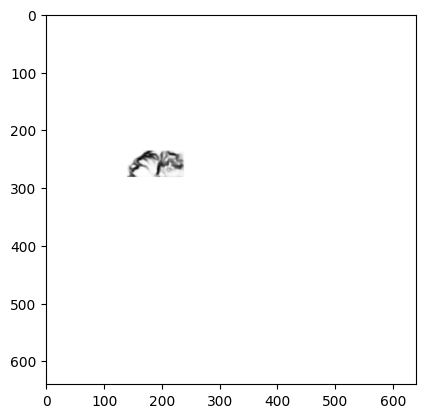

In [5]:
num_layouts = 10

layouts = hedVPG.generate_layouts(im_shape=(640,640,3), num_object_per_layout=1, num_layouts=num_layouts)
prompts = hedVPG.generate_prompts(layouts=layouts)
vis_priors = hedVPG.generate_vis_priors(layouts=layouts, im_shape=(640,640,1))
print(prompts[0])
plt.imshow(vis_priors[0], cmap='Greys')

In [37]:
ckpt_path = '/media/data/dad/cnet/experiments/coco10novel/epoch=99-step=2999.ckpt'
#ckpt_path = '/home/ubuntu/dad/ControlNet/models/control_sd15_hed.pth'

model = create_model('/home/ubuntu/dad/ControlNet/models/cldm_v15.yaml').cpu()
model.load_state_dict(load_state_dict(ckpt_path, location='cuda'))
model = model.cuda()
ddim_sampler = DDIMSampler(model)

ControlLDM: Running in eps-prediction mode
Setting up MemoryEfficientCrossAttention. Query dim is 320, context_dim is None and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 320, context_dim is 768 and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 320, context_dim is None and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 320, context_dim is 768 and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 640, context_dim is None and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 640, context_dim is 768 and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 640, context_dim is None and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 640, context_dim is 768 and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 1280, context_dim is None and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 1280, context_

In [38]:
def process_hed(model, ddim_sampler, vis_prior, prompt, a_prompt, n_prompt, num_samples, ddim_steps, guess_mode, strength, scale, seed, eta):
    with torch.no_grad():
        detected_map = HWC3(vis_prior.astype(np.uint8))
        H, W, C = detected_map.shape

        control = torch.from_numpy(detected_map.copy()).float().cuda() / 255.0
        control = torch.stack([control for _ in range(num_samples)], dim=0)
        control = einops.rearrange(control, 'b h w c -> b c h w').clone()

        if seed == -1:
            seed = random.randint(0, 65535)
        seed_everything(seed)

        if config.save_memory:
            model.low_vram_shift(is_diffusing=False)

        cond = {"c_concat": [control], "c_crossattn": [model.get_learned_conditioning([prompt + ', ' + a_prompt] * num_samples)]}
        un_cond = {"c_concat": None if guess_mode else [control], "c_crossattn": [model.get_learned_conditioning([n_prompt] * num_samples)]}
        shape = (4, H // 8, W // 8)

        if config.save_memory:
            model.low_vram_shift(is_diffusing=True)

        model.control_scales = [strength * (0.825 ** float(12 - i)) for i in range(13)] if guess_mode else ([strength] * 13)  # Magic number. IDK why. Perhaps because 0.825**12<0.01 but 0.826**12>0.01
        samples, intermediates = ddim_sampler.sample(ddim_steps, num_samples,
                                                     shape, cond, verbose=False, eta=eta,
                                                     unconditional_guidance_scale=scale,
                                                     unconditional_conditioning=un_cond)

        if config.save_memory:
            model.low_vram_shift(is_diffusing=False)

        x_samples = model.decode_first_stage(samples)
        x_samples = (einops.rearrange(x_samples, 'b c h w -> b h w c') * 127.5 + 127.5).cpu().numpy().clip(0, 255).astype(np.uint8)

        results = [x_samples[i] for i in range(num_samples)]
    return [detected_map] + results

In [39]:
results = []
edited_prompts = ["picture of a " + p for p in prompts]
print(edited_prompts)
num_samples_per_layout = 3
for idx in range(num_layouts):
    results_per_layout = process_hed(
                    model=model,
                    ddim_sampler=ddim_sampler,
                    vis_prior=vis_priors[idx],
                    prompt=prompts[idx],
                    #a_prompt="realistic, real, photo", 
                    #n_prompt="blurry, unclear, duplicate, distortion, lowres, bad anatomy, error, cropped, low quality", 
                    a_prompt="",
                    n_prompt="",
                    num_samples=num_samples_per_layout, 
                    ddim_steps=50, 
                    guess_mode=False, 
                    strength=1., 
                    scale=9., 
                    seed=-1, 
                    eta=0.,
                )[1:]
    results.append(results_per_layout)


Global seed set to 17611


['picture of a cat', 'picture of a cat', 'picture of a motorcycle', 'picture of a person', 'picture of a chair', 'picture of a airplane', 'picture of a potted plant', 'picture of a car', 'picture of a potted plant', 'picture of a cat']
Data shape for DDIM sampling is (3, 4, 80, 80), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|█████████████████████████████████████████████████████████████| 50/50 [00:52<00:00,  1.04s/it]
Global seed set to 45221


Data shape for DDIM sampling is (3, 4, 80, 80), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|█████████████████████████████████████████████████████████████| 50/50 [00:52<00:00,  1.04s/it]
Global seed set to 27615


Data shape for DDIM sampling is (3, 4, 80, 80), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|█████████████████████████████████████████████████████████████| 50/50 [00:52<00:00,  1.04s/it]
Global seed set to 15034


Data shape for DDIM sampling is (3, 4, 80, 80), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|█████████████████████████████████████████████████████████████| 50/50 [00:52<00:00,  1.04s/it]
Global seed set to 18303


Data shape for DDIM sampling is (3, 4, 80, 80), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|█████████████████████████████████████████████████████████████| 50/50 [00:52<00:00,  1.04s/it]
Global seed set to 18186


Data shape for DDIM sampling is (3, 4, 80, 80), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|█████████████████████████████████████████████████████████████| 50/50 [00:52<00:00,  1.04s/it]
Global seed set to 22252


Data shape for DDIM sampling is (3, 4, 80, 80), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|█████████████████████████████████████████████████████████████| 50/50 [00:52<00:00,  1.04s/it]
Global seed set to 14388


Data shape for DDIM sampling is (3, 4, 80, 80), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|█████████████████████████████████████████████████████████████| 50/50 [00:52<00:00,  1.04s/it]
Global seed set to 1614


Data shape for DDIM sampling is (3, 4, 80, 80), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|█████████████████████████████████████████████████████████████| 50/50 [00:52<00:00,  1.04s/it]
Global seed set to 26470


Data shape for DDIM sampling is (3, 4, 80, 80), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|█████████████████████████████████████████████████████████████| 50/50 [00:52<00:00,  1.04s/it]


In [40]:
import matplotlib.pyplot as plt
import numpy as np
def plot_figures(results, vis_priors, num_layouts = num_layouts, num_samples_per_layout=num_samples_per_layout):

    fig = plt.figure()
    
    image_heigt = 320 # Height of the image
    image_width = 320 # Width of the image

    pixels = np.zeros(((num_samples_per_layout+1)*image_heigt,num_layouts*image_width, 3), dtype=np.uint8) # Create
    for col in range(num_layouts):
        for row in range(num_samples_per_layout+1):
            image = results[col][row-1] if row else np.concatenate([vis_priors[col]]*3,axis=2)
            resized = cv2.resize(image, (image_width, image_heigt)).astype(np.uint8)
            pixels[row*image_heigt:row*image_heigt+image_heigt,col*image_heigt:col*image_heigt+image_heigt] = resized
    plt.imshow(pixels, cmap='gray')
    plt.axis('off')
    plt.show()
    cv2.imwrite("visualize_vispriors.png", pixels[:,:,::-1])

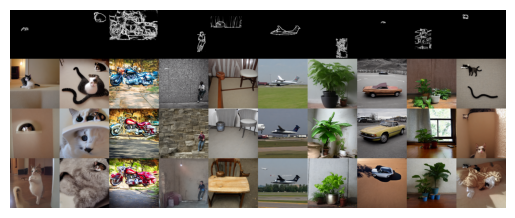

In [41]:
plot_figures(results, vis_priors)

In [11]:
'''
fig = plt.figure()

#subplot(r,c) provide the no. of rows and columns
f, axes = plt.subplots(num_layouts,num_samples_per_layout+1, sharex=True, sharey=True)

print(prompts)

for col in range(num_layouts):
    for row in range(num_samples_per_layout):
        if row:
            axes[col][row].imshow(results[col][row-1])
        else:
            axes[col][row].imshow(vis_priors[col], cmap='Greys')

for ax in axes.ravel():
    ax.set_axis_off()
    ax.title.set_visible(False)

plt.subplots_adjust(hspace=0, wspace=0)
plt.show()
'''

"\nfig = plt.figure()\n\n#subplot(r,c) provide the no. of rows and columns\nf, axes = plt.subplots(num_layouts,num_samples_per_layout+1, sharex=True, sharey=True)\n\nprint(prompts)\n\nfor col in range(num_layouts):\n    for row in range(num_samples_per_layout):\n        if row:\n            axes[col][row].imshow(results[col][row-1])\n        else:\n            axes[col][row].imshow(vis_priors[col], cmap='Greys')\n\nfor ax in axes.ravel():\n    ax.set_axis_off()\n    ax.title.set_visible(False)\n\nplt.subplots_adjust(hspace=0, wspace=0)\nplt.show()\n"

In [12]:
from pycocotools.coco import COCO  # https://github.com/cocodataset/cocoapi/blob/master/PythonAPI/pycocoDemo.ipynb
coco = COCO(labels_path)
cat = coco.loadCats([1, 2, 3, 4, 5, 6, 7, 9, 16, 17, 18, 19, 20, 21, 44, 62, 63, 64, 67, 72])
cat

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


[{'supercategory': 'person', 'id': 1, 'name': 'person'},
 {'supercategory': 'vehicle', 'id': 2, 'name': 'bicycle'},
 {'supercategory': 'vehicle', 'id': 3, 'name': 'car'},
 {'supercategory': 'vehicle', 'id': 4, 'name': 'motorcycle'},
 {'supercategory': 'vehicle', 'id': 5, 'name': 'airplane'},
 {'supercategory': 'vehicle', 'id': 6, 'name': 'bus'},
 {'supercategory': 'vehicle', 'id': 7, 'name': 'train'},
 {'supercategory': 'vehicle', 'id': 9, 'name': 'boat'},
 {'supercategory': 'animal', 'id': 16, 'name': 'bird'},
 {'supercategory': 'animal', 'id': 17, 'name': 'cat'},
 {'supercategory': 'animal', 'id': 18, 'name': 'dog'},
 {'supercategory': 'animal', 'id': 19, 'name': 'horse'},
 {'supercategory': 'animal', 'id': 20, 'name': 'sheep'},
 {'supercategory': 'animal', 'id': 21, 'name': 'cow'},
 {'supercategory': 'kitchen', 'id': 44, 'name': 'bottle'},
 {'supercategory': 'furniture', 'id': 62, 'name': 'chair'},
 {'supercategory': 'furniture', 'id': 63, 'name': 'couch'},
 {'supercategory': 'furni

In [13]:
imgIds = coco.getImgIds(catIds=[9])
imgs = coco.loadImgs(imgIds)

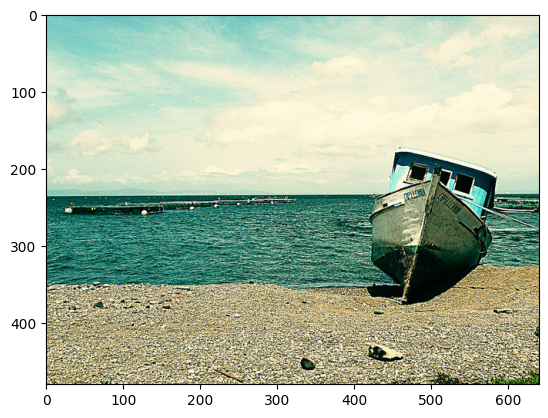

In [14]:
plt.imshow(cv2.imread(os.path.join(im_folder, imgs[0]['file_name']))[:,:,::-1])